# Quickstart

This is a quick baseline model and to help you get familiar with the data format, submission process and so on. I figure it's worth sharing for those wanting to get up and running quickly using fastai :)

This isn't a tutorial - although there are some suggestions at the bottom of the notebook for directins to explore.

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Setup

Assuming provided files are present. Installing fastai (may need to restart runtime)

In [10]:
!pip install fastai --upgrade

In [11]:
# Extracting the files
!unzip '/content/drive/MyDrive/indabaX_cameroon/indabaX_cameroon_image.zip'

Archive:  /content/drive/MyDrive/indabaX_cameroon/indabaX_cameroon_image.zip
   creating: indabaX_cameroon/Images/
  inflating: indabaX_cameroon/Images/ImageID_001CIZAK.jpg  
  inflating: indabaX_cameroon/Images/ImageID_00S98W9Q.jpg  
  inflating: indabaX_cameroon/Images/ImageID_01DN9DG2.jpg  
  inflating: indabaX_cameroon/Images/ImageID_01M08V8L.jpg  
  inflating: indabaX_cameroon/Images/ImageID_027OASAQ.jpg  
  inflating: indabaX_cameroon/Images/ImageID_02L60GSN.jpg  
  inflating: indabaX_cameroon/Images/ImageID_02LRIWPC.jpg  
  inflating: indabaX_cameroon/Images/ImageID_03O6QBJ2.jpg  
  inflating: indabaX_cameroon/Images/ImageID_03V7BLUR.jpg  
  inflating: indabaX_cameroon/Images/ImageID_03YY3GIU.jpg  
  inflating: indabaX_cameroon/Images/ImageID_04K4UCHR.jpg  
  inflating: indabaX_cameroon/Images/ImageID_05PH38OL.jpg  
  inflating: indabaX_cameroon/Images/ImageID_0687RZ5Q.jpg  
  inflating: indabaX_cameroon/Images/ImageID_06M9O942.jpg  
  inflating: indabaX_cameroon/Images/ImageID_

# Load data and put in dataloaders

Fastai makes it relatively easy to get our training data from the dataframe into a format we can use for training.

In [12]:
from fastai.vision.all import *
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [46]:
train = pd.read_csv('/content/drive/MyDrive/indabaX_cameroon/indaba/Train.csv')
print(train.shape)
train.head(2)

(1548, 2)


,Image_ids,class
0,ImageID_ZWY4MO08,fruit_healthy
1,ImageID_OZQDOU6U,fruit_brownspot


In [47]:
test = pd.read_csv('/content/drive/MyDrive/indabaX_cameroon/indaba/Test.csv')
print(test.shape)
test.head(2)

(516, 1)


,Image_ids
0,ImageID_GXD1UROG
1,ImageID_U9W52JFZ


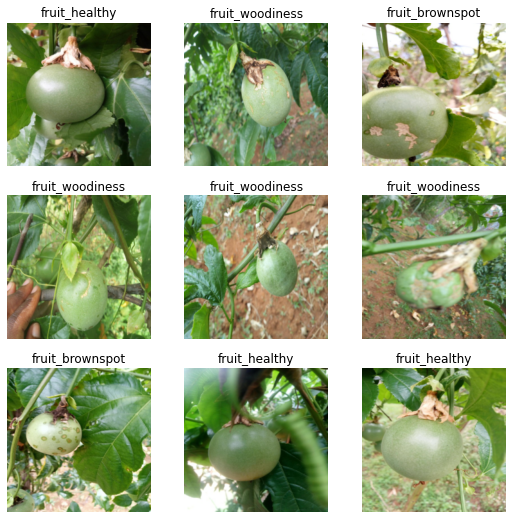

In [48]:
# Create the dataloaders
dls = ImageDataLoaders.from_df(train, path="indabaX_cameroon/Images/", 
                               fn_col='Image_ids', 
                               label_col='class', 
                               suff='.jpg', item_tfms=Resize(224), num_workers=0)
dls.show_batch()

# Quick Model

No fancy training here - this only took a minute, just enough time for me to organise my previous cells a little :)

In [49]:
learn = cnn_learner(dls, resnet34, metrics=accuracy)

# Preds on test set

I didn't read the info page at all, so my first sub consisted of probabilities. The score of 0 was enough for me to re-evaluate and realize they want a ranked list of predictions. np.argsort to the rescue :) The way I've done it here isn't the most efficient but who cares - it runs and we can get a submission on the leaderboard asap!

EDIT: I had to come back and fix this - I missed that the row order differs between test and sample sub. 

In [50]:
preds = learn.get_preds(dl=dls.test_dl(test)) # Getting the predicted probabilities

In [51]:
# Checking the format
ss = pd.read_csv('/content/drive/MyDrive/indabaX_cameroon/indaba/Sample_submission.csv')
ss.head(2)

,Image_ids,class
0,ImageID_GXD1UROG,NaN
1,ImageID_U9W52JFZ,NaN


In [52]:
preds[0][0], np.argsort(preds[0])[0] # We have probs and then index if they were sorted (low to high)

(TensorBase([0.0127, 0.5695, 0.4178]), TensorBase([0, 2, 1]))

In [53]:
learn.dls.vocab # The labels in the order used by the model

['fruit_brownspot', 'fruit_healthy', 'fruit_woodiness']

In [54]:
# Need to make sure order is right - note staring with the highest prob
test['class'] = [learn.dls.vocab[p[2]] for p in np.argsort(preds[0])]
test.head()

,Image_ids,class
0,ImageID_GXD1UROG,fruit_healthy
1,ImageID_U9W52JFZ,fruit_healthy
2,ImageID_18ZU2YP5,fruit_healthy
3,ImageID_8RBI9ZMH,fruit_healthy
4,ImageID_ZYJELERW,fruit_healthy


In [55]:
test.head()

,Image_ids,class
0,ImageID_GXD1UROG,fruit_healthy
1,ImageID_U9W52JFZ,fruit_healthy
2,ImageID_18ZU2YP5,fruit_healthy
3,ImageID_8RBI9ZMH,fruit_healthy
4,ImageID_ZYJELERW,fruit_healthy


In [56]:
ss.head(2)

,Image_ids,class
0,ImageID_GXD1UROG,NaN
1,ImageID_U9W52JFZ,NaN


In [57]:
# Merging them into ss
ss = pd.merge(ss['Image_ids'], test[['Image_ids', 'class']], how='left', on='Image_ids')
ss.head()

,Image_ids,class
0,ImageID_GXD1UROG,fruit_healthy
1,ImageID_U9W52JFZ,fruit_healthy
2,ImageID_18ZU2YP5,fruit_healthy
3,ImageID_8RBI9ZMH,fruit_healthy
4,ImageID_ZYJELERW,fruit_healthy


In [58]:
ss.to_csv('submission_zindi.csv', index=False) 

In [59]:
ss.head()

,Image_ids,class
0,ImageID_GXD1UROG,fruit_healthy
1,ImageID_U9W52JFZ,fruit_healthy
2,ImageID_18ZU2YP5,fruit_healthy
3,ImageID_8RBI9ZMH,fruit_healthy
4,ImageID_ZYJELERW,fruit_healthy


# Where next?

This model gives me a feel for the task. But what would one do next? More training? Here are some (uninformed) suggestions:
- Explore the data.
- Everything is very...green in these pics. Perhaps we can do a color transform to bring out the features more clearly?
- ... after playing around, we can then start trying more training, bigger models etc. But don't do that until you've seen what gains you can get by better treatment of the data (cropping etc)!